# Using Neural Networks for Subgrid Forcing Parameterizations

Now that we have generated coarsened, low-resolution datasets, we can now feed these datasets as training data for our parameterized machine learning (ML) training sessions. In this section, we will focus on one category of parameterizations, fully convolutional neural networks (FCNNs), though will explore other strata of parameterizations in subsequent sections. 

In [1]:
# Import required modules
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pyqg
import json
import fsspec
import pyqg_parameterization_benchmarks.coarsening_ops as coarsening
from pyqg_parameterization_benchmarks.neural_networks import FCNNParameterization, FullyCNN

%matplotlib inline

Although, there are a total of 105 options for constructing FCNN paramaterizations attributed within the paper, we will be solely restricting ourselves to focusing in depth to one parameterization in this guide. We will be training a FCNN on the values of PV to estimate total PV subgrid forcing, computed with Operator 1 (spectral truncation + sharp filter).

We must first load this FCNN paramterization as follows:

In [ ]:
inputs = [('q', 0), ('q', 1), ('u', 0), ('u', 1), ('v', 0), ('v', 1)]
targets = [[('u_subgrid_forcing', 0)], [('u_subgrid_forcing', 1)]]
fcnn_qu_to_Su2 = FullyCNN(inputs, targets[0])
fcnn_qu_to_Su2.fit(np.array(inputs), np.array(targets))

In [ ]:
fcnn_qu_to_Su2.save('/home/jovyan/models/fcnn_qu_to_Su2/models/0')

In [2]:
param = FCNNParameterization('/home/jovyan/pyqg_parameterization_benchmarks/models/fcnn_q_to_Sqtot1') # 
param.models[0]

inputs:  [('q', 0), ('q', 1)]
targets:  [('q_forcing_total', 0)]
input_scale:  <pyqg_parameterization_benchmarks.neural_networks.ChannelwiseScaler object at 0x7fb64e416470>
output_scale:  <pyqg_parameterization_benchmarks.neural_networks.ChannelwiseScaler object at 0x7fb70e8120b0>
{'padding': 'circular'}
inputs:  [('q', 0), ('q', 1)]
targets:  [('q_forcing_total', 1)]
input_scale:  <pyqg_parameterization_benchmarks.neural_networks.ChannelwiseScaler object at 0x7fb70e813790>
output_scale:  <pyqg_parameterization_benchmarks.neural_networks.ChannelwiseScaler object at 0x7fb70e811cf0>
{'padding': 'circular'}


FullyCNN(
  (0): Conv2d(2, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=circular)
  (1): ReLU()
  (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=circular)
  (4): ReLU()
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (7): ReLU()
  (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (10): ReLU()
  (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (13): ReLU()
  (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

We must also load the coarsened, low-resolution dataset that we will be using as training data for the FCNN parameterization. 

In [ ]:
hires_model = pyqg.QGModel(nx=256, dt=3600.0, tmax=311040000.0, tavestart=155520000.0)

op1 = coarsening.Operator1(hires_model, 64)
initial_snapshot = op1.m2.to_dataset()zsw
initial_snapshot['q_forcing_total'] = (['lev', 'y', 'x'], op1.q_forcing_total)
initial_snapshot['q_subgrid_forcing'] = (['lev', 'y', 'x'], op1.subgrid_forcing('q'))
initial_snapshot['u_subgrid_forcing'] = (['lev', 'y', 'x'], op1.subgrid_forcing('u'))
initial_snapshot['v_subgrid_forcing'] = (['lev', 'y', 'x'], op1.subgrid_forcing('v'))
initial_snapshot['uq_subgrid_flux'] = (['lev', 'y', 'x'], op1.subgrid_fluxes('q')[0])
initial_snapshot['vq_subgrid_flux'] = (['lev', 'y', 'x'], op1.subgrid_fluxes('q')[1])
initial_snapshot['uu_subgrid_flux'] = (['lev', 'y', 'x'], op1.subgrid_fluxes('u')[0])
initial_snapshot['uv_subgrid_flux'] = (['lev', 'y', 'x'], op1.subgrid_fluxes('v')[0])
initial_snapshot['vv_subgrid_flux'] = (['lev', 'y', 'x'], op1.subgrid_fluxes('v')[1])
snapshots = [initial_snapshot]
for _ in hires_model.run_with_snapshots(tsnapint=1000*hires_model.dt):
    op1 = coarsening.Operator1(hires_model, 64)
    snapshot = op1.m2.to_dataset()
    snapshot['q_forcing_total'] = (['lev', 'y', 'x'], op1.q_forcing_total)
    snapshot['q_subgrid_forcing'] = (['lev', 'y', 'x'], op1.subgrid_forcing('q'))
    snapshot['u_subgrid_forcing'] = (['lev', 'y', 'x'], op1.subgrid_forcing('u'))
    snapshot['v_subgrid_forcing'] = (['lev', 'y', 'x'], op1.subgrid_forcing('v'))
    snapshot['uq_subgrid_flux'] = (['lev', 'y', 'x'], op1.subgrid_fluxes('q')[0])
    snapshot['vq_subgrid_flux'] = (['lev', 'y', 'x'], op1.subgrid_fluxes('q')[1])
    snapshot['uu_subgrid_flux'] = (['lev', 'y', 'x'], op1.subgrid_fluxes('u')[0])
    snapshot['uv_subgrid_flux'] = (['lev', 'y', 'x'], op1.subgrid_fluxes('v')[0])
    snapshot['vv_subgrid_flux'] = (['lev', 'y', 'x'], op1.subgrid_fluxes('v')[1])
    snapshots.append(snapshot)
coarsened_snapshots = xr.concat(snapshots, dim='time')

In [21]:
coarsened_snapshots

<xarray.Dataset>
Dimensions:            (time: 87, lev: 2, y: 64, x: 64, l: 64, k: 33, lev_mid: 1)
Coordinates:
  * time               (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  * lev                (lev) int64 1 2
  * lev_mid            (lev_mid) float64 1.5
  * x                  (x) float64 7.812e+03 2.344e+04 ... 9.766e+05 9.922e+05
  * y                  (y) float64 7.812e+03 2.344e+04 ... 9.766e+05 9.922e+05
  * l                  (l) float64 0.0 6.283e-06 ... -1.257e-05 -6.283e-06
  * k                  (k) float64 0.0 6.283e-06 ... 0.0001948 0.0002011
Data variables: (12/23)
    q                  (time, lev, y, x) float64 5.892e-07 ... -1.618e-06
    u                  (time, lev, y, x) float64 -3.533e-05 ... 0.008675
    v                  (time, lev, y, x) float64 -0.000102 ... 0.00295
    ufull              (time, lev, y, x) float64 0.02496 0.02498 ... 0.008675
    vfull              (time, lev, y, x) float64 -0.000102 ... 0.00295
    qh                 (time, lev, l, k) complex128 (0.0022936210479330968+0j...
    ...                 ...
    v_subgrid_forcing  (time, lev, y, x) float64 -3.462e-13 ... -6.936e-11
    uq_subgrid_flux    (time, lev, y, x) float64 1.081e-12 ... -4.8e-10
    vq_subgrid_flux    (time, lev, y, x) float64 -6.699e-13 ... 1.271e-09
    uu_subgrid_flux    (time, lev, y, x) float64 2.252e-09 ... 7.572e-06
    uv_subgrid_flux    (time, lev, y, x) float64 9.061e-09 ... -6.005e-06
    vv_subgrid_flux    (time, lev, y, x) float64 2.686e-08 ... 1.067e-05
Attributes: (12/23)
    pyqg:beta:       1.5e-11
    pyqg:delta:      0.25
    pyqg:del2:       0.8
    pyqg:dt:         3600.0
    pyqg:filterfac:  23.6
    pyqg:L:          1000000.0
    ...              ...
    pyqg:tc:         0
    pyqg:tmax:       1576800000.0
    pyqg:twrite:     1000.0
    pyqg:W:          1000000.0
    title:           pyqg: Python Quasigeostrophic Model
    reference:       https://pyqg.readthedocs.io/en/latest/index.html

In [ ]:
coarsened_snapshots.to_zarr('gs://leap-persistent/pbluc/forcing1', mode='w') 

In [2]:
coarsened_snapshots1 = xr.open_zarr('gs://leap-persistent/pbluc/forcing1').load()

We can also utilize preexisting datasets as an alternative to our own coarsened data. 

In [3]:
eddy_forcing1 = xr.open_zarr('gs://leap-persistent/pbluc/eddy/forcing1').isel(run=0).load()
eddy_forcing1['q_forcing_total'] = eddy_forcing1.dqdt_bar - eddy_forcing1.dqbar_dt

In [4]:
eddy_forcing1

<xarray.Dataset>
Dimensions:            (l: 64, k: 33, lev: 2, time: 87, y: 64, x: 64, lev_mid: 1)
Coordinates:
  * k                  (k) float32 0.0 6.283e-06 ... 0.0001948 0.0002011
  * l                  (l) float32 0.0 6.283e-06 ... -1.257e-05 -6.283e-06
  * lev                (lev) int32 1 2
  * lev_mid            (lev_mid) float32 1.5
  * time               (time) float32 0.0 3.6e+06 7.2e+06 ... 3.06e+08 3.096e+08
  * x                  (x) float32 7.812e+03 2.344e+04 ... 9.766e+05 9.922e+05
  * y                  (y) float32 7.812e+03 2.344e+04 ... 9.766e+05 9.922e+05
Data variables: (12/37)
    APEflux            (l, k) float32 -0.0 8.36e-15 ... 3.116e-27 -4.992e-33
    APEgen             float32 7.488e-11
    APEgenspec         (l, k) float32 0.0 -2.465e-15 ... 1.682e-38 -0.0
    Dissspec           (l, k) float32 -0.0 -0.0 -0.0 ... -2.671e-26 -8.976e-32
    EKE                (lev) float32 0.002634 8.083e-05
    EKEdiss            float32 7.484e-11
    ...                 ...
    v                  (time, lev, y, x) float32 -0.001655 ... -0.005067
    v_subgrid_forcing  (time, lev, y, x) float32 -7.855e-13 ... 1.62e-10
    vfull              (time, lev, y, x) float32 -0.001655 ... -0.005067
    vq_subgrid_flux    (time, lev, y, x) float32 9.977e-11 ... 5.031e-10
    vv_subgrid_flux    (time, lev, y, x) float32 -1.337e-06 ... 3.477e-06
    q_forcing_total    (time, lev, y, x) float32 -2.647e-16 ... 1.591e-14
Attributes: (12/26)
    hires:           256
    lores:           64
    pyqg:L:          1000000.0
    pyqg:M:          4096
    pyqg:W:          1000000.0
    pyqg:beta:       1.5e-11
    ...              ...
    pyqg:tc:         0
    pyqg:tmax:       311040000.0
    pyqg:twrite:     1000.0
    pyqg_params:     {"nx": 64, "dt": 3600.0, "tmax": 311040000.0, "tavestart...
    reference:       https://pyqg.readthedocs.io/en/latest/index.html
    title:           Subgrid forcing dataset generated by coarsening nx=256 p...

We can test offline

In [ ]:
preds = param.test_offline(coarsened_snapshots1)
preds

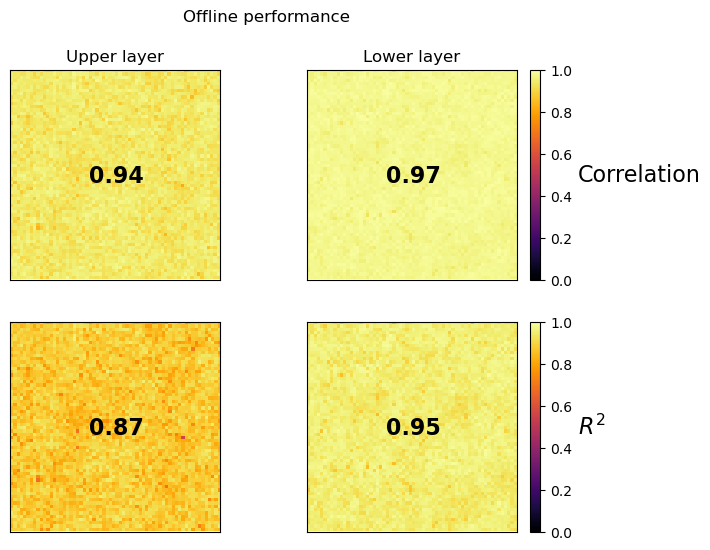

In [52]:
def imshow(arr):
    plt.imshow(arr, vmin=0, vmax=1, cmap='inferno')
    mean = arr.mean().data
    plt.text(32, 32, f"{mean:.2f}", color=('white' if mean<0.75 else 'black'),
             fontweight='bold', ha='center', va='center', fontsize=16)
    plt.xticks([]); plt.yticks([])
    
def colorbar(label):
    plt.colorbar().set_label(label, fontsize=16,rotation=0,ha='left',va='center')
    
plt.figure(figsize=(7.6,6)).suptitle("Offline performance")

for z in [0,1]:
    plt.subplot(2,2,z+1,title=f"{['Upper','Lower'][z]} layer")
    imshow(preds.q_forcing_total_spatial_correlation.isel(lev=z))
    if z: colorbar("Correlation")
    
for z in [0,1]:
    plt.subplot(2,2,z+3)
    imshow(preds.q_forcing_total_spatial_skill.isel(lev=z))
    if z: colorbar("$R^2$")